In [1]:
# Install required libraries
!pip -q install matplotlib scipy mne numpy scikit-learn

# Import packages
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne.time_frequency import psd_array_welch
from pathlib import Path
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 40.2 MB/s eta 0:00:00


In [2]:
# Define file path and load raw EEG data
file_path = '/content/drive/MyDrive/S001R03.edf'
raw = mne.io.read_raw_edf(file_path, preload=True)

Extracting EDF parameters from /content/drive/MyDrive/S001R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Using matplotlib as 2D backend.


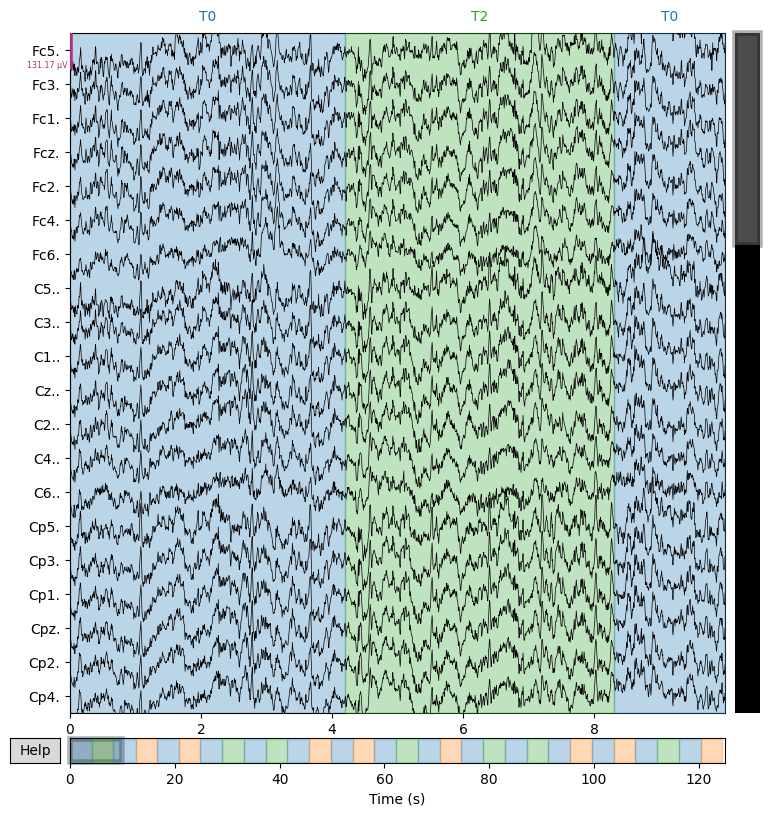

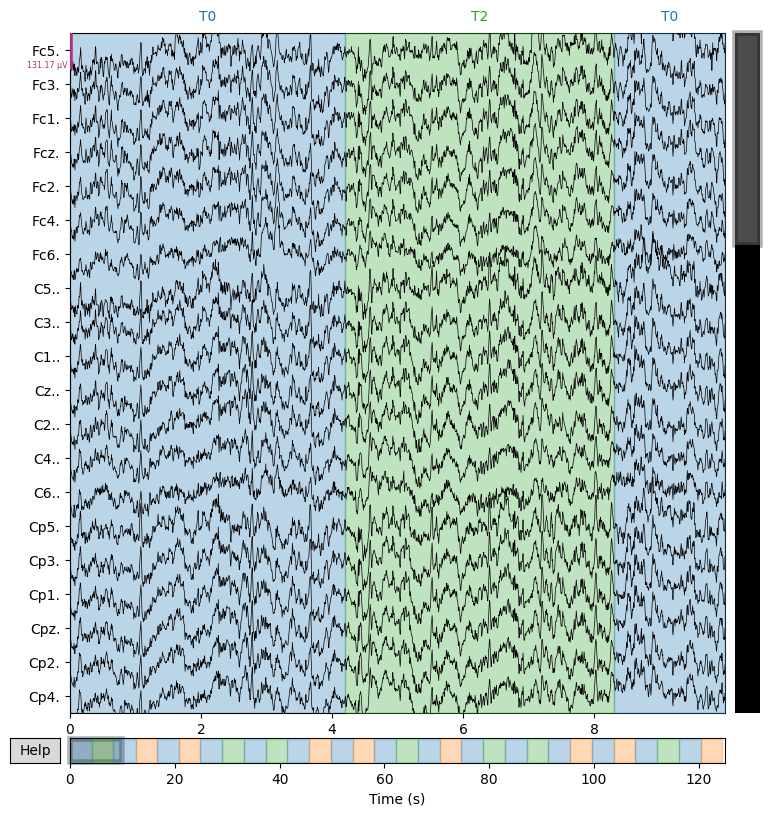

In [3]:
# Visualize raw data
raw.plot(n_channels=20, scalings='auto', title='Raw EEG Data')

In [4]:
# Set reference and apply frequency filters
raw.set_eeg_reference('average', projection=True)
raw.filter(l_freq=7.0, h_freq=30.0, fir_design='firwin', skip_by_annotation='edge')

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>

In [5]:
# Extract events and create epochs
event_id = dict(T1=2, T2=3)
events, _ = mne.events_from_annotations(raw, event_id=event_id)
epochs = mne.Epochs(raw, events, event_id=dict(hands=2, feet=3),
                    tmin=-1.0, tmax=4.0, proj=True, picks='eeg',
                    baseline=None, preload=True)

Used Annotations descriptions: [np.str_('T1'), np.str_('T2')]
Not setting metadata
15 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 15 events and 801 original time points ...
0 bad epochs dropped


In [7]:
# Calculate Power Spectral Density (PSD)
data = epochs.get_data()
sfreq = epochs.info['sfreq']
psds, freqs = psd_array_welch(data, sfreq=sfreq, fmin=7, fmax=30, n_fft=512)

Effective window size : 3.200 (s)


In [8]:
# Extract frequency band features
alpha = np.mean(psds[:, :, (freqs >= 8) & (freqs <= 12)], axis=-1)
beta = np.mean(psds[:, :, (freqs >= 12) & (freqs <= 30)], axis=-1)
X = np.hstack([alpha, beta])
y = epochs.events[:, -1]

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [12]:
# Train and evaluate SVM model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_pca, y_train)
y_pred_svm = svm_model.predict(X_test_pca)

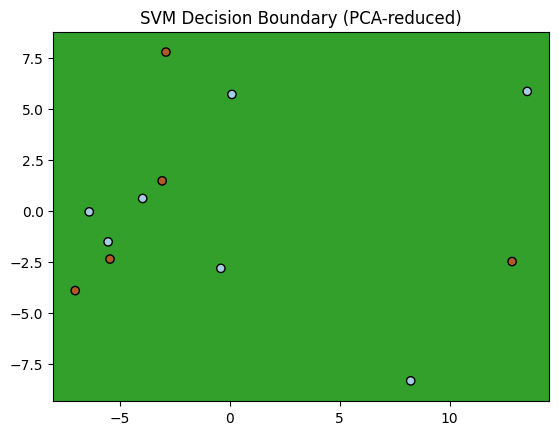

In [13]:
# Display SVM decision boundaries
DecisionBoundaryDisplay.from_estimator(svm_model, X_train_pca, response_method="predict", cmap=plt.cm.Paired)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.title("SVM Decision Boundary (PCA-reduced)")
plt.show()

In [15]:
# Find best k for KNN model
n_samples_fit = X_train_pca.shape[0] # Checking how many samples we actually have in the training set

k_values = range(1, n_samples_fit + 1)

accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_pca, y_train)
    accuracies.append(knn.score(X_test_pca, y_test))

best_k = k_values[np.argmax(accuracies)]
print(f"The best k is: {best_k}")

The best k is: 1


In [16]:
# Train final KNN model and predict
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_pca, y_train)
y_pred_knn = best_knn.predict(X_test_pca)

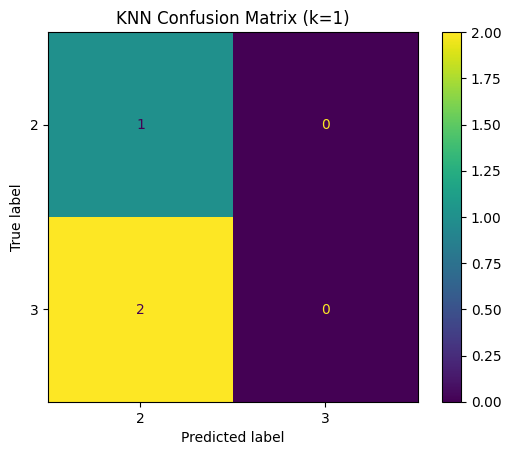

In [17]:
# Display KNN confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot()
plt.title(f"KNN Confusion Matrix (k={best_k})")
plt.show()

In [18]:
# Print classification metrics
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print(f"Best KNN Accuracy (k={best_k}): {max(accuracies):.2f}")

SVM Classification Report:
               precision    recall  f1-score   support

           2       0.33      1.00      0.50         1
           3       0.00      0.00      0.00         2

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3

Best KNN Accuracy (k=1): 0.33


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Acknowledgements

#### EEG Motor Movement/Imagery Dataset (Sept. 9, 2009, midnight)

A set of 64-channel EEGs from subjects who performed a series of motor/imagery tasks has been contributed to PhysioNet by the developers of the BCI2000 instrumentation system for brain-computer interface research. (link: https://physionet.org/content/eegmmidb/1.0.0/S001/#files-panel)

Original publication:
Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE Transactions on Biomedical Engineering 51(6):1034-1043, 2004.

Standard citation for PhysioNet:
Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220. RRID:SCR_007345.